In [4]:
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import math as mth
from scipy import stats as st
import seaborn as sns
%matplotlib inline

In [5]:
#import chart_studio.plotly as py
#import cufflinks as cf
import seaborn as sns
#import plotly.express as px
%matplotlib inline
#from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
#init_notebook_mode(connected=True)
#cf.go_offline()
#import plotly.graph_objects as go

In [6]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [7]:
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Project description

Team-project with marketing department on boosting revenue for big online store. The main goal of the project is to define the most promising hypothesis in terms of increasing revenue of the store, launch an A/B test, and analyze the results. 

Outline of analysis

- Loading the data, checking for duplicates and mismatched values, converting data types to the necessary formats. 
- Prioritizing hypotheses using ICE and RICE methods, ranging priority. 
- Launching an A/B test.
- Analyzing the results of the A/B test: calculation of basic indicators for conversion rate and average order size, comparing results for both groups, testing hypothesis using statistical tests.
- Summurizing results of our analysis and making recommendation on the A/B test continuance

# Download data

In this part of our project we will load the files with data and will preprocess the data. 

In [8]:
hypotheses = pd.read_csv('hypotheses_us.csv')
hypotheses.head()

,Hypothesis;Reach;Impact;Confidence;Effort
0,Add two new channels for attracting traffic. T...
1,Launch your own delivery service. This will sh...
2,Add product recommendation blocks to the store...
3,Change the category structure. This will incre...
4,Change the background color on the main page. ...


We have a problem with this dataframe, we need to divide the data to the columns, so that it would be more convenient for further analysis. 

In [9]:
# We will divide our data to several columns and rename them:
hypotheses = hypotheses['Hypothesis;Reach;Impact;Confidence;Effort'].str.split(';', expand=True)
hypotheses.columns = ['hypothesis', 'reach', 'impact', 'confidence', 'effort']
# We will convert numerical data:
hypotheses['reach'] = hypotheses['reach'].astype('int')
hypotheses['impact'] = hypotheses['impact'].astype('int')
hypotheses['confidence'] = hypotheses['confidence'].astype('int')
hypotheses['effort'] = hypotheses['effort'].astype('int')
hypotheses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int32 
 2   impact      9 non-null      int32 
 3   confidence  9 non-null      int32 
 4   effort      9 non-null      int32 
dtypes: int32(4), object(1)
memory usage: 344.0+ bytes


In [10]:
orders = pd.read_csv('orders_us.csv')
orders.head()
orders.info()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionId  1197 non-null   int64  
 1   visitorId      1197 non-null   int64  
 2   date           1197 non-null   object 
 3   revenue        1197 non-null   float64
 4   group          1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 46.9+ KB


In [11]:
# Converting date to the datetime format: 
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B


In [12]:
orders['date'].min()
orders['date'].max()

Timestamp('2019-08-01 00:00:00')

Timestamp('2019-08-31 00:00:00')

In [13]:
orders = orders.drop_duplicates()
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   float64       
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 56.1+ KB


We will check if we have any users that present in both groups. 

In [14]:
ordersA = orders[orders['group']=='A']
ordersB = orders[orders['group']=='B']
group_A = ordersA['visitorId'].unique()
users_duplicates_orders = ordersB[ordersB['visitorId'].isin(group_A)]
len(users_duplicates_orders)

92

We do have common users in both groups. Since we don't have possibility to define to each of the group the user belongs, we should completly remove them from both groups, otherwise we would not be able to analyze results correctly. 

In [15]:
# We will remove users that are signed in both groups: 
orders_filt = orders[~orders['visitorId'].isin(users_duplicates_orders['visitorId'])]
len(orders_filt)

1016

In [16]:
orders_filt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1016 non-null   int64         
 1   visitorId      1016 non-null   int64         
 2   date           1016 non-null   datetime64[ns]
 3   revenue        1016 non-null   float64       
 4   group          1016 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 47.6+ KB


In [17]:
orders_A = orders_filt[orders_filt['group']=='A']
orders_B = orders_filt[orders_filt['group']=='B']

In [18]:
visits = pd.read_csv('visits_us.csv')
visits.head()
visits.info()

,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    62 non-null     object
 1   group   62 non-null     object
 2   visits  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [19]:
# Converting date to the datetime format: 
visits['date'] = visits['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)
visits.head()

,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [20]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    62 non-null     datetime64[ns]
 1   group   62 non-null     object        
 2   visits  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


In this part we loaded the data, checked for the duplicates, converted data to the needed formats. We have founded that some of our users belonged to two groupes. It is impossible for us to define to each of the group these users indeed belong. We removed these users from the dataset in order to get correct resuls of analysis. 
Now we are ready to start analysis and working with hypotheses. 

# Part 1. Prioritizing Hypotheses

We will use following parameters for rating our hypotheses in calculating ICE score: 
Impact — how strongly this update will affect the users, their experience, and their satisfaction with the product
Confidence — how sure you are that your product will affect them in this way
Effort — how much will it cost to test the hypothesis

In [21]:
# We will calculate ICE and RICE parameter for each hypothese: 
hypotheses['ice_score'] = ((hypotheses['impact']*hypotheses['confidence'])/hypotheses['effort']).round()
pd.options.display.max_colwidth = 210
hypotheses.sort_values(by='ice_score', ascending=False)


,hypothesis,reach,impact,confidence,effort,ice_score
8,Launch a promotion that gives users discounts on their birthdays,1,9,9,5,16.0
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6,13.0
7,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5,11.0
6,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3,8.0
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3,7.0
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10,2.0
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8,1.0
4,Change the background color on the main page. This will increase user engagement,3,1,1,1,1.0
5,Add a customer review page. This will increase the number of orders,3,2,2,3,1.0


Hypothese "Lanuch a promotion" has the highest ice score, followed by hypothese "Add two new channels for attracting traffic" and "Add a subscription form to all the main pages". 

We will use following parameters for rating our hypotheses in calculating RICE score: 
Reach — how many users will be affected by the update you want to introduce
Impact — how strongly this update will affect the users, their experience, and their satisfaction with the product
Confidence — how sure you are that your product will affect them in this way
Effort — how much will it cost to test the hypothesi

In [22]:
hypotheses['rice_score']= (hypotheses['reach']* hypotheses['impact']*hypotheses['confidence'])/hypotheses['effort']
pd.options.display.max_colwidth = 210
hypotheses.sort_values(by='rice_score', ascending=False)

,hypothesis,reach,impact,confidence,effort,ice_score,rice_score
7,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5,11.0,112.0
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3,7.0,56.0
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6,13.0,40.0
6,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3,8.0,40.0
8,Launch a promotion that gives users discounts on their birthdays,1,9,9,5,16.0,16.2
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8,1.0,9.0
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10,2.0,4.0
5,Add a customer review page. This will increase the number of orders,3,2,2,3,1.0,4.0
4,Change the background color on the main page. This will increase user engagement,3,1,1,1,1.0,3.0


After implementing rice score we see a different situation with hypotheses: 
The hypotheses with the highes rice score (in descending order):
 - "Add a subscription form to all the main pages"
 - "Add product recommendation blocks to the store"
 - "Add two new channels for attracting traffic". 
 
 The factor that influence on the difference in score between two methods is using in calculating RICE score factor "reach" which reflectshow many users will be affected by the update we want to introduce. 
 
I would highlight the following hypotheses: "Add a subscription form to all the main pages", since it has hightest RICE score and 3d position in ICE score and "Add two new channels for attracting traffic" since it has 3d RICE and 2d ICE scores. 

# Part 2. A/B Test Analysis

## Graph cumulative revenue by group.

In [23]:
# We will group data of the orders by date: 
orders_A_daily = orders_A.groupby(['date']).agg({'revenue': 'sum', 'transactionId':'nunique'}).reset_index()
orders_A_daily.columns = ['date', 'revenue', 'orders']
orders_A_daily['cum_revenue']=orders_A_daily['revenue'].cumsum()
orders_A_daily.head()

,date,revenue,orders,cum_revenue
0,2019-08-01,2266.6,23,2266.6
1,2019-08-02,1468.3,19,3734.9
2,2019-08-03,1815.2,24,5550.1
3,2019-08-04,675.5,11,6225.6
4,2019-08-05,1398.0,22,7623.6


In [24]:
orders_B_daily = orders_B.groupby(['date']).agg({'revenue': 'sum', 'transactionId':'nunique'}).reset_index()
orders_B_daily.columns = ['date', 'revenue', 'orders']
orders_B_daily['cum_revenue']=orders_B_daily['revenue'].cumsum()
orders_B_daily.head()

,date,revenue,orders,cum_revenue
0,2019-08-01,967.2,17,967.2
1,2019-08-02,2568.1,23,3535.3
2,2019-08-03,1071.6,14,4606.9
3,2019-08-04,1531.6,14,6138.5
4,2019-08-05,1449.3,21,7587.8


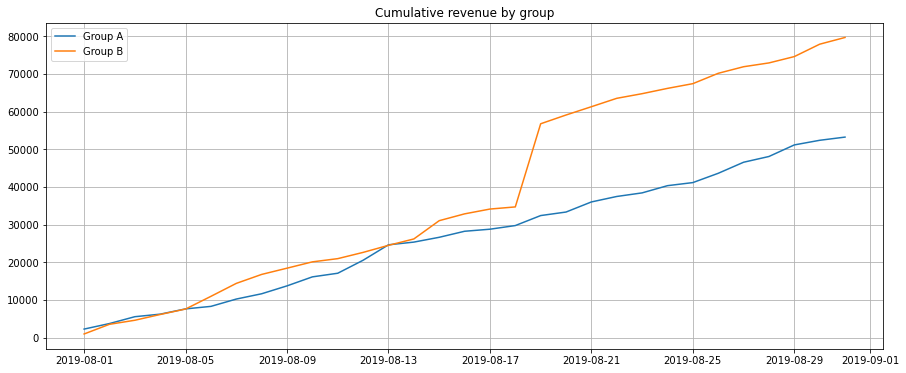

In [25]:
plt.rcParams["figure.figsize"] = (15,6)
plt.plot(orders_A_daily['date'], orders_A_daily['cum_revenue'], label='Group A');
plt.plot(orders_B_daily['date'], orders_B_daily['cum_revenue'], label='Group B');
plt.legend();
plt.title('Cumulative revenue by group');
plt.grid();

In the beginnins of the test both groups demonstrate similar results. After 5 days of the testing results of group B slowly increased. On 19th of August we see a rapid peak and this difference kept until the end of the month.  

## Graph cumulative average order size by group. 

In [26]:
orders_A_daily['cum_orders']=orders_A_daily['orders'].cumsum()
orders_A_daily['avg_order'] = orders_A_daily['revenue'] / orders_A_daily['orders']
orders_A_daily['cum_avg_order'] = orders_A_daily['cum_revenue'] / orders_A_daily['cum_orders']
orders_A_daily.head()

,date,revenue,orders,cum_revenue,cum_orders,avg_order,cum_avg_order
0,2019-08-01,2266.6,23,2266.6,23,98.547826,98.547826
1,2019-08-02,1468.3,19,3734.9,42,77.278947,88.926190
2,2019-08-03,1815.2,24,5550.1,66,75.633333,84.092424
3,2019-08-04,675.5,11,6225.6,77,61.409091,80.851948
4,2019-08-05,1398.0,22,7623.6,99,63.545455,77.006061


In [27]:
orders_B_daily['cum_orders']=orders_B_daily['orders'].cumsum()
orders_B_daily['avg_order'] = orders_B_daily['revenue'] / orders_B_daily['orders']
orders_B_daily['cum_avg_order'] = orders_B_daily['cum_revenue'] / orders_B_daily['cum_orders']
orders_B_daily.head()

,date,revenue,orders,cum_revenue,cum_orders,avg_order,cum_avg_order
0,2019-08-01,967.2,17,967.2,17,56.894118,56.894118
1,2019-08-02,2568.1,23,3535.3,40,111.656522,88.382500
2,2019-08-03,1071.6,14,4606.9,54,76.542857,85.312963
3,2019-08-04,1531.6,14,6138.5,68,109.400000,90.272059
4,2019-08-05,1449.3,21,7587.8,89,69.014286,85.256180


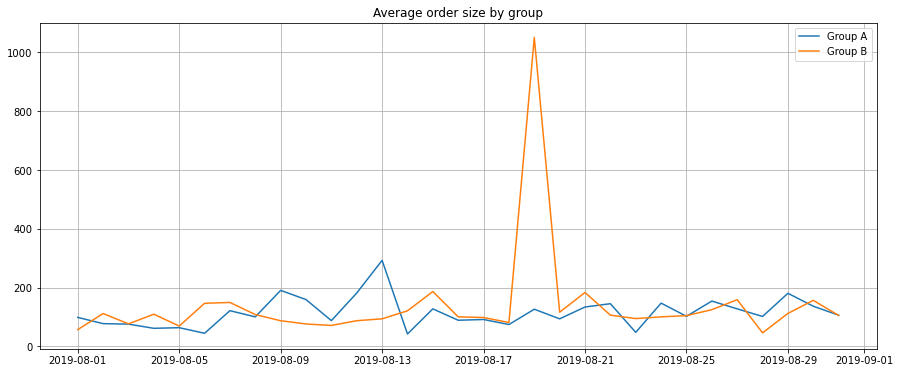

In [28]:
plt.plot(orders_A_daily['date'], orders_A_daily['avg_order'], label='Group A');
plt.plot(orders_B_daily['date'], orders_B_daily['avg_order'], label='Group B');
plt.legend();
plt.title('Average order size by group');
plt.grid();

There is no significant difference between two groups in the average order size, group B demonstrates good results on 08-09-2019 and on 08-13-2019, when the group A goes down. On the 19th of August we see a rapid peak in average order size group B that most probably also influenced on the cumulative revenue that we saw on the previous graph. It can be the result of the outliers and we should check it in the next stage. 

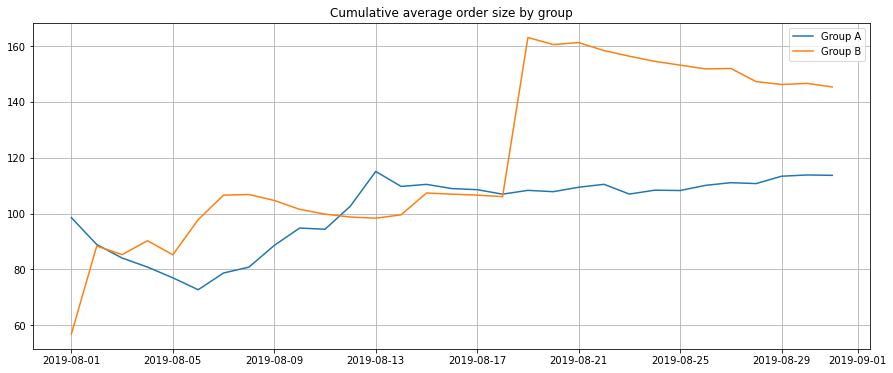

In [29]:
plt.rcParams["figure.figsize"] = (15,6)
plt.plot(orders_A_daily['date'], orders_A_daily['cum_avg_order'], label='Group A');
plt.plot(orders_B_daily['date'], orders_B_daily['cum_avg_order'], label='Group B');
plt.legend();
plt.title('Cumulative average order size by group');
plt.grid();

The dynamics of the cumulative average order size changes in different directions: when group A increases group B decreases and vice versa until the rapid growth of the cumulative average order size on 08-19-2019 that we already saw in the previous graphs. 

## Graph the relative difference in cumulative average order size for group B compared with group A. 

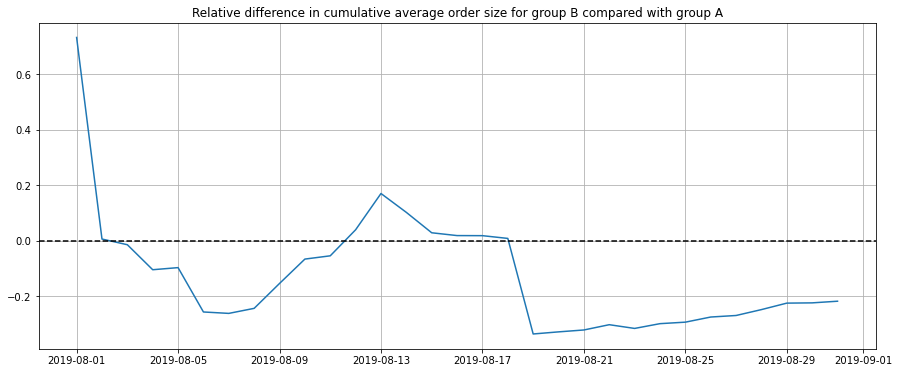

In [30]:
CumulativeData = orders_A_daily.merge(orders_B_daily, left_on='date', right_on='date', how='left', suffixes=['A', 'B']);
plt.plot(CumulativeData['date'], CumulativeData['cum_avg_orderA']/CumulativeData['cum_avg_orderB']-1);
plt.axhline(y=0, color='black', linestyle='--'); 
plt.title('Relative difference in cumulative average order size for group B compared with group A');
plt.grid();

On this graphs we see that in period 08.02 - 08.12 cumulative average order size of group B is less compared to group A, after that we see a short growth of group A and after 08.19 group B grew rapidly compared to the group B and kept its leadership till the end of the month. 

## Calculate each group's conversion rate as the ration of orders to the number of visits for each day. 

In [31]:
# We will divide the data about number of visits to two groups: A and B:
visits_A = visits[visits['group']=='A']
visits_B = visits[visits['group']=='B']

# Now we will create a dataframe and calculate conversion rate for group A: 
conversion_A = visits_A.merge(orders_A_daily[['date', 'orders']], how='left', on='date')
conversion_A['conversion'] = conversion_A['orders']/conversion_A['visits']
# And for group B:
conversion_B = visits_B.merge(orders_B_daily[['date', 'orders']], how='left', on='date')
conversion_B['conversion'] = conversion_B['orders']/conversion_B['visits']

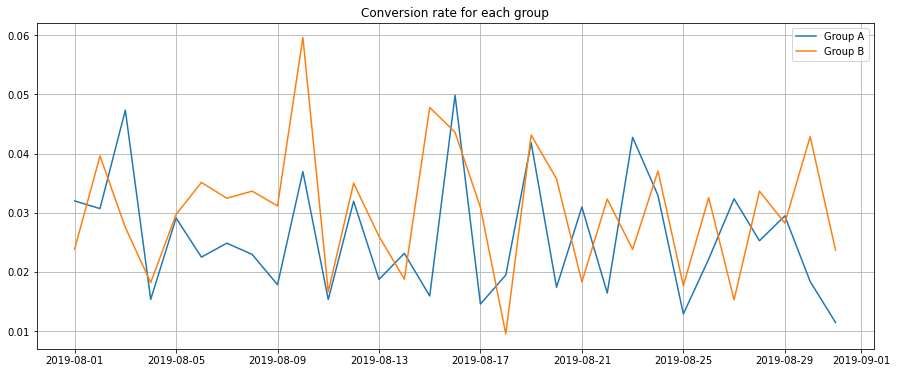

In [32]:
plt.plot(conversion_A['date'], conversion_A['conversion'], label='Group A');
plt.plot(conversion_B['date'], conversion_B['conversion'], label='Group B');
plt.legend();
plt.title('Conversion rate for each group');
plt.grid();

For most of the month, both groups show similar dynamics: peaks and declines in the same periods. For the last third of the month, the charts show more multidirectional dynamics. In overall conversion of group B is a little bit higher than of the group A. (2.9% vs. 2.5%)

In [33]:
# We will calculate cumulative conversion for both groups:
conversion_A['cum_visits'] = conversion_A['visits'].cumsum()
conversion_A['cum_orders'] = conversion_A['orders'].cumsum()
conversion_A['cum_conversion'] = conversion_A['cum_orders']/conversion_A['cum_visits']
conversion_A.head()

conversion_B['cum_visits'] = conversion_B['visits'].cumsum()
conversion_B['cum_orders'] = conversion_B['orders'].cumsum()
conversion_B['cum_conversion'] = conversion_B['cum_orders']/conversion_B['cum_visits']
conversion_B.head()

,date,group,visits,orders,conversion,cum_visits,cum_orders,cum_conversion
0,2019-08-01,A,719,23,0.031989,719,23,0.031989
1,2019-08-02,A,619,19,0.030695,1338,42,0.031390
2,2019-08-03,A,507,24,0.047337,1845,66,0.035772
3,2019-08-04,A,717,11,0.015342,2562,77,0.030055
4,2019-08-05,A,756,22,0.029101,3318,99,0.029837


,date,group,visits,orders,conversion,cum_visits,cum_orders,cum_conversion
0,2019-08-01,B,713,17,0.023843,713,17,0.023843
1,2019-08-02,B,581,23,0.039587,1294,40,0.030912
2,2019-08-03,B,509,14,0.027505,1803,54,0.029950
3,2019-08-04,B,770,14,0.018182,2573,68,0.026428
4,2019-08-05,B,707,21,0.029703,3280,89,0.027134


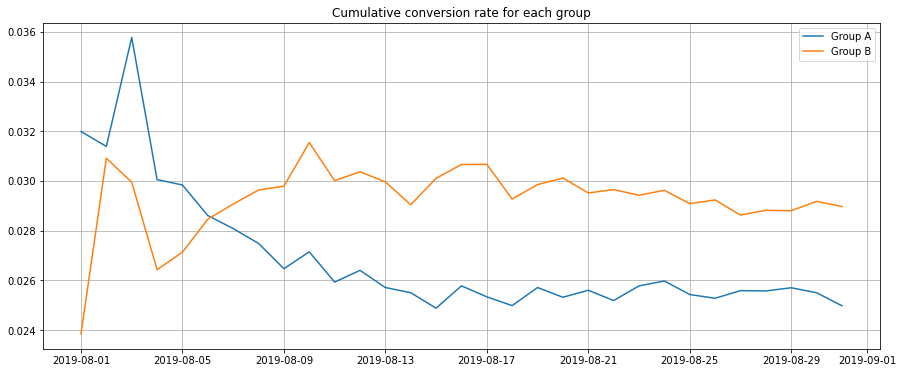

In [34]:
plt.plot(conversion_A['date'], conversion_A['cum_conversion'], label='Group A');
plt.plot(conversion_B['date'], conversion_B['cum_conversion'], label='Group B');
plt.legend();
plt.title('Cumulative conversion rate for each group');
plt.grid();

After fluctuating during the first five days of the test, the results of the two groups crossed over and after that group B confidently shows the better results in cumulative conversion compared to results of group A. 

In [35]:
print('Overall conversion group A:', conversion_A['orders'].sum()/conversion_A['visits'].sum())
print('Overall conversion group B:', conversion_B['orders'].sum()/conversion_B['visits'].sum())

Overall conversion group A: 0.02497865072587532
Overall conversion group B: 0.02897018397124128


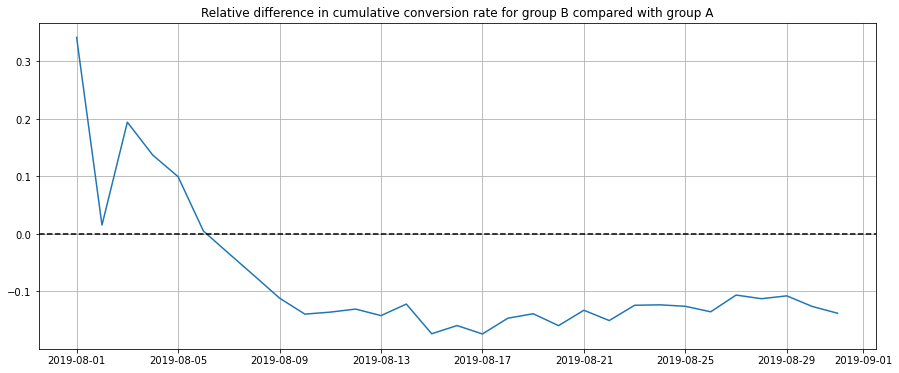

In [36]:
CumulativeConversion = conversion_A.merge(conversion_B, left_on='date', right_on='date', how='left', suffixes=['A', 'B']);
plt.plot(CumulativeConversion['date'], CumulativeConversion['cum_conversionA']/CumulativeConversion['cum_conversionB']-1);
plt.axhline(y=0, color='black', linestyle='--'); 
plt.title('Relative difference in cumulative conversion rate for group B compared with group A');
plt.grid();

On the graph of relative difference we also can see that starting from the 6th day of test, group B demonstrates stable better results in conversion rate compared to group A.

## Plot a scatter chart of the number of orders per user. 

In [37]:
ordersByUsers = (
    orders_filt.drop(['group', 'revenue', 'date'], axis=1)
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)

ordersByUsers.columns = ['visitorId', 'orders']
ordersByUsers.sort_values(by='orders', ascending=False).head()

,visitorId,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3


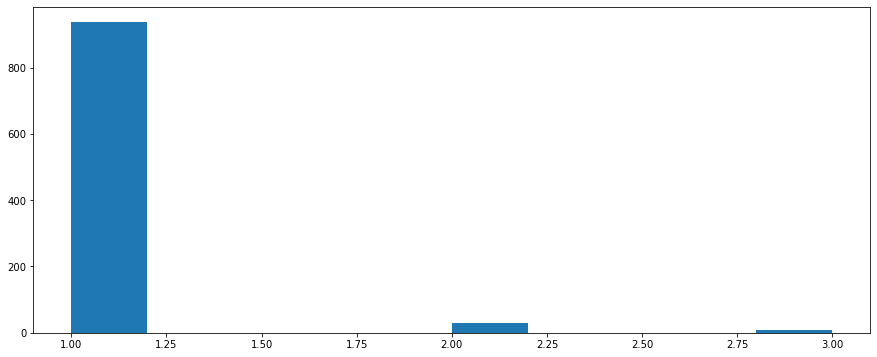

In [38]:
plt.hist(ordersByUsers['orders']);

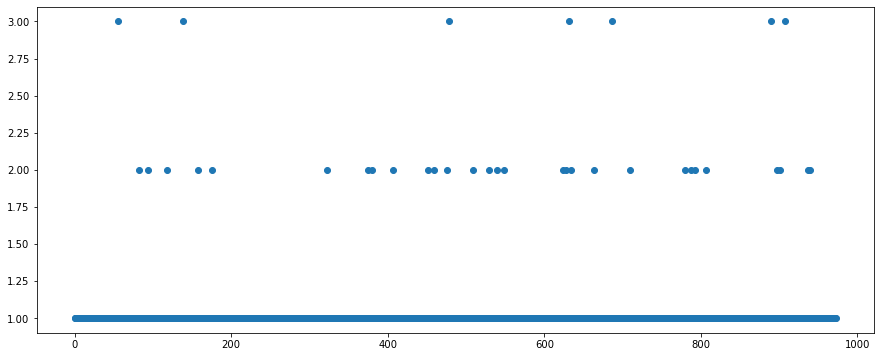

In [39]:
x_values = pd.Series(range(0,len(ordersByUsers)));
plt.scatter(x_values, ordersByUsers['orders']) ;

The vast majority of the users make one order, only a small percentage make two and even fewer make 3 orders. We do not see more than three orders from one user. 

## Calculate the 95th and 99th percentiles for the number of orders per user. Define the point at which a data point becomes an anomaly. 

In [40]:
print(np.percentile(ordersByUsers['orders'], [95, 99])) 

[1. 2.]


99% of our users make 2 or 1 order, so in this case 3 orders per user can be considered to be an outlier. 

## Plot a scatter chart of order prices. 

In [41]:
orders_filt.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B


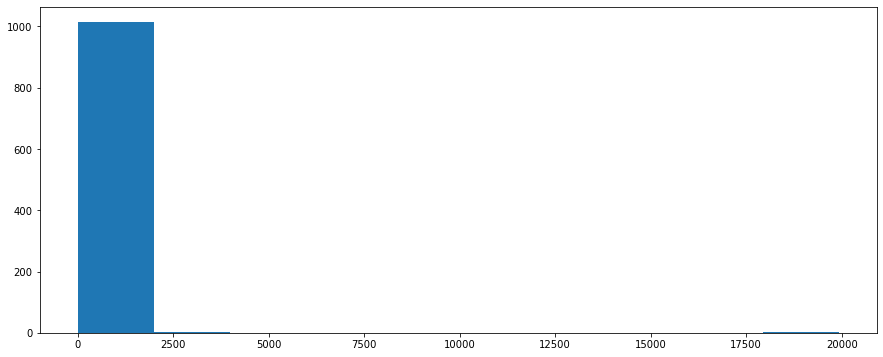

In [42]:
#Let's build a historgam of order price distribution: 
plt.hist(orders_filt['revenue']);

<AxesSubplot:xlabel='revenue'>

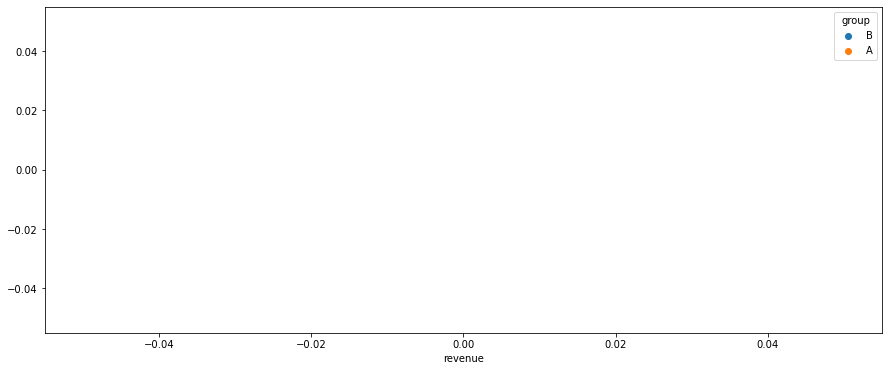

In [43]:
x_values = pd.Series(range(0, len(orders_filt['revenue'])));
#plt.scatter(x_values, orders_filt['revenue']);
sns.scatterplot(data=orders_filt, x="revenue", hue="group")

The vast majority of the users make orders of less than 1000. 

## Calculate the 95th and 99th percentiles of the order prices. Define the point at which a data point becomes an anomaly. 

In [44]:
print(np.percentile(orders_filt['revenue'], [95, 99])) 

[414.275 830.3  ]


99% of the users make orders less than 830 revenue. We can consider orders that are more from this number to be an outlier and remove them from our data. 

We will consolidate all users that either make very expensive orders (with revenue more than 830) or make too many orders (more than 2) and will use this data for further steps to get filtered data. 

In [45]:
usersWithManyOrders = ordersByUsers[ordersByUsers['orders']>2]['visitorId']
usersWithExpensiveOrders = orders_filt[orders_filt['revenue'] > 830]['visitorId']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0).drop_duplicates()
abnormalUsers.head(5)
abnormalUsers.shape 

55      249864742
138     611059232
478    2108163459
632    2742574263
687    2988190573
Name: visitorId, dtype: int64

(19,)

We have 19 anomalous users in total. These are users that either did very expensive orders (higher than 830) or did more than 2 orders. 

In [46]:
orders_new = orders_filt[~orders_filt['visitorId'].isin(abnormalUsers)]
len(orders_new)

983

In [47]:
# Now we will use filtered data for creating basic dataframes that will be used in further calculations: 
orders_A_new = orders_new[orders_new['group']=='A']
orders_B_new = orders_new[orders_new['group']=='B']

# We will group filtered data of the orders by date: 
orders_A_daily_new = orders_A_new.groupby(['date']).agg({'revenue': 'sum', 'transactionId':'nunique'}).reset_index()
orders_A_daily_new.columns = ['date', 'revenue', 'orders']
orders_A_daily_new['cum_revenue']=orders_A_daily_new['revenue'].cumsum()
orders_A_daily_new.head()

orders_B_daily_new = orders_B_new.groupby(['date']).agg({'revenue': 'sum', 'transactionId':'nunique'}).reset_index()
orders_B_daily_new.columns = ['date', 'revenue', 'orders']
orders_B_daily_new['cum_revenue']=orders_B_daily_new['revenue'].cumsum()
orders_B_daily_new.head()

,date,revenue,orders,cum_revenue
0,2019-08-01,1779.3,18,1779.3
1,2019-08-02,1438.3,18,3217.6
2,2019-08-03,1815.2,24,5032.8
3,2019-08-04,675.5,11,5708.3
4,2019-08-05,1398.0,22,7106.3


,date,revenue,orders,cum_revenue
0,2019-08-01,967.2,17,967.2
1,2019-08-02,2568.1,23,3535.3
2,2019-08-03,1071.6,14,4606.9
3,2019-08-04,1531.6,14,6138.5
4,2019-08-05,1449.3,21,7587.8


## Main graphs with filtered data

### Cumulative revenue by group

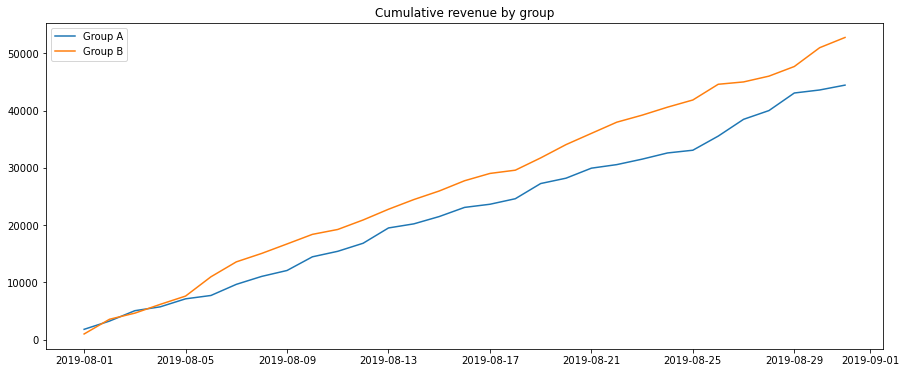

In [48]:
orders_A_daily_new['cum_revenue']=orders_A_daily_new['revenue'].cumsum()
orders_B_daily_new['cum_revenue']=orders_B_daily_new['revenue'].cumsum()
plt.rcParams["figure.figsize"] = (15,6)
plt.plot(orders_A_daily_new['date'], orders_A_daily_new['cum_revenue'], label='Group A');
plt.plot(orders_B_daily_new['date'], orders_B_daily_new['cum_revenue'], label='Group B');
plt.legend();
plt.title('Cumulative revenue by group');

After removing outliers we don't see the peak that we had before. The results of group B in cumulative revenue are higher compared to the group A. 

### Cumulative average order size by group

In [49]:
orders_A_daily_new['cum_orders']=orders_A_daily_new['orders'].cumsum()
orders_A_daily_new['avg_order'] = orders_A_daily_new['revenue'] / orders_A_daily_new['orders']
orders_A_daily_new['cum_avg_order'] = orders_A_daily_new['cum_revenue'] / orders_A_daily_new['cum_orders']
orders_B_daily_new['cum_orders']=orders_B_daily_new['orders'].cumsum()
orders_B_daily_new['avg_order'] = orders_B_daily_new['revenue'] / orders_B_daily_new['orders']
orders_B_daily_new['cum_avg_order'] = orders_B_daily_new['cum_revenue'] / orders_B_daily_new['cum_orders']

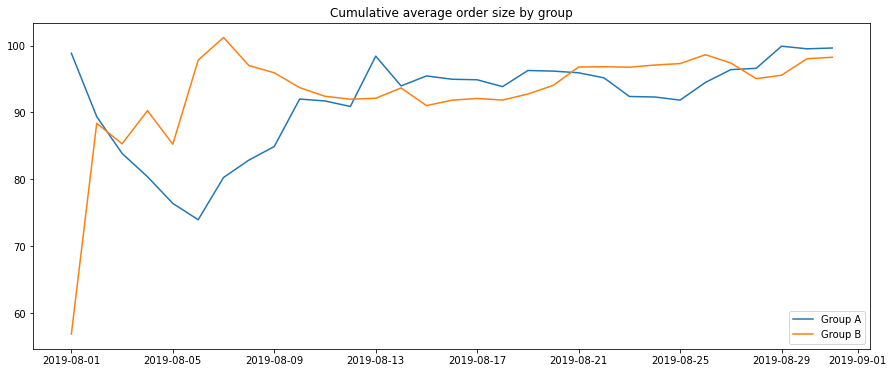

In [50]:
plt.rcParams["figure.figsize"] = (15,6)
plt.plot(orders_A_daily_new['date'], orders_A_daily_new['cum_avg_order'], label='Group A');
plt.plot(orders_B_daily_new['date'], orders_B_daily_new['cum_avg_order'], label='Group B');
plt.legend();
plt.title('Cumulative average order size by group');

Now, we can say with certainty that the peak we saw in the chart based on the raw data was due to the outliers. Now the results of cumulative average order size of both group are close one to another, and we can not single out a leader. 

### Relative difference in cumulative average order size 

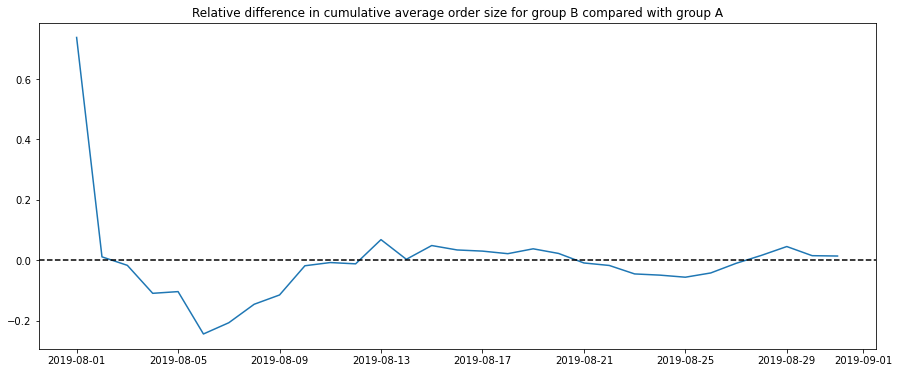

In [51]:
CumulativeData_new = orders_A_daily_new.merge(orders_B_daily_new, left_on='date', right_on='date', how='left', suffixes=['A', 'B']);
plt.plot(CumulativeData_new['date'], CumulativeData_new['cum_avg_orderA']/CumulativeData_new['cum_avg_orderB']-1);
plt.axhline(y=0, color='black', linestyle='--'); 
plt.title('Relative difference in cumulative average order size for group B compared with group A');

After filtering data we got more smooth graphis without a peak that a definitly was the result of anomal order. Group B demonstrates better results compared to group A in cumulative revenue, but in average order size none of the groups takes advantage. 

## Find the statistical significance of the difference in conversion between the groups using the raw data. 

### Total conversion check

In [52]:
# Calculating total conversion for group A:
A_trials = conversion_A['visits'].sum()
print("Trials:", A_trials)
A_successes = conversion_A['orders'].sum()
print("Successes:", A_successes)
print('Conversion Group A: {0:0.1%}'.format(A_successes/A_trials))

Trials: 18736
Successes: 468
Conversion Group A: 2.5%


In [53]:
# Calculating total conversion for group B:
B_trials = conversion_B['visits'].sum()
print("Trials:", B_trials)
B_successes = conversion_B['orders'].sum()
print("Successes:", B_successes)
print('Conversion Group B: {0:0.1%}'.format(B_successes/B_trials))

Trials: 18916
Successes: 548
Conversion Group B: 2.9%


Now we can formulate hypotheses for testing: 
    
- H0 (Null): There is no statistical significance between conversion of Group A and Group B. 
- H1 (Alternative): Conversion of Group B is higher than conversion of Group A. 
    
Since we are comparing proportion of two population we will use z-test for testing our hypotheses.  

In [54]:
alpha = .05 # significance level

successes = np.array([A_successes, B_successes])
trials = np.array([A_trials, B_trials])

# success proportion in the first group:
p1 = successes[0]/trials[0]

# success proportion in the second group:
p2 = successes[1]/trials[1]

# success proportion in the combined dataset:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# the difference between the datasets' proportions
difference = p1 - p2 

# calculating the statistic in standard deviations of the standard normal distribution
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# setting up the standard normal distribution (mean 0, standard deviation 1)
distr = st.norm(0, 1)  

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-value: ', p_value)

if (p_value < alpha):
    print("Rejecting the null hypothesis: there is a significant difference between the proportions")
else:
    print("Failed to reject the null hypothesis: there is no reason to consider the proportions different")

p-value:  0.016851380434703023
Rejecting the null hypothesis: there is a significant difference between the proportions


Since p value is less then 0.05 we can say that there is a statistically significant difference between the proportions. And since conversion rate of group B is more than group A (2.9% vs. 2.5%) we can conclude that conversion rate of group B is higher than the one of group A.  

### Average daily conversion

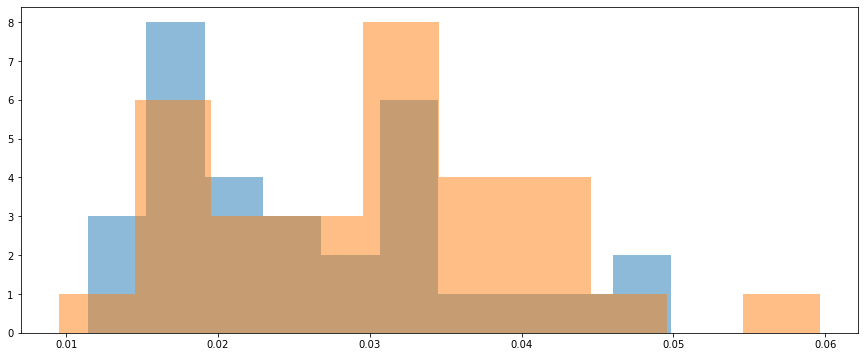

In [55]:
plt.hist(conversion_A['conversion'], alpha=0.5, label='Group A');
plt.hist(conversion_B['conversion'], alpha=0.5, label='Group B');

In [56]:
print('Mean group A:', conversion_A['conversion'].mean())
print('Mean group B:', conversion_B['conversion'].mean())
print('Median group A:', conversion_A['conversion'].median())
print('Median group B:', conversion_B['conversion'].median())

Mean group A: 0.025890306958716493
Mean group B: 0.030424002805202716
Median group A: 0.02312925170068027
Median group B: 0.03114754098360656


Now we can formulate hypotheses for testing:

- H0 (Null): There is no statistical significance between conversion of Group A and Group B.
- H1 (Alternative): Conversion of Group B is higher than conversion of Group A.

Since we are comparing the means of population we will either ttest or Mann-Whitney test for testing our hypotheses.
To define the exact test, we need to check whether our population have normal distiribution with the help of Shapiro test. 
If both of the samples have normal distribution we will use ttest, otherwise we will use tesst Mann_Whitney.

In [57]:
alpha = .05 # significance level

results1 = st.shapiro(conversion_A['conversion'])
p_value1 = results1[1] 

results2 = st.shapiro(conversion_B['conversion'])
p_value2 = results2[1]

if (p_value1 > alpha) and (p_value2 > alpha):
    print('Both samples seem to have normal distribution, ttest can be used')
else: 
    print('One of the samples has not normal distribution, test Mann_whitney should be used')

Both samples seem to have normal distribution, ttest can be used


In [58]:
#We will perform Levene’s Test to determine whether surf customers and ultimate customers have equal variances: 
st.levene(conversion_A['conversion'], conversion_B['conversion'], center='mean')
st.levene(conversion_A['conversion'], conversion_B['conversion'], center='median')

LeveneResult(statistic=0.012535822118248652, pvalue=0.9112260916374787)

LeveneResult(statistic=0.0003349179434919493, pvalue=0.985459640402054)

In both methods, the p-value is more than 0.05 and that mean that in this case we cannot reject a null-hypothese and say that the variance for group A and group B differ. 
So we will use equal_var=True for our ttest.

In [59]:
alpha = 0.05  # critical statistical significance level
# if the p-value is less than alpha, we reject the hypothesis
# the null hypotesis is that two population are equal

result2 = st.ttest_ind(conversion_A['conversion'], conversion_B['conversion'], equal_var=True)

print('p-value: ', result2.pvalue)

if result2.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We cannot reject the null hypothesis") 

p-value:  0.09573715593918651
We cannot reject the null hypothesis


We can't conclude that there is s statistically significant difference between conversion rate of two groups. 

## Find the statistical significance of the difference in average order size between the groups using the raw data

In [60]:
orders_A_daily['average_check'] = orders_A_daily['revenue']/orders_A_daily['orders']
orders_B_daily['average_check'] = orders_B_daily['revenue']/orders_B_daily['orders']
orders_A_daily.head()

,date,revenue,orders,cum_revenue,cum_orders,avg_order,cum_avg_order,average_check
0,2019-08-01,2266.6,23,2266.6,23,98.547826,98.547826,98.547826
1,2019-08-02,1468.3,19,3734.9,42,77.278947,88.926190,77.278947
2,2019-08-03,1815.2,24,5550.1,66,75.633333,84.092424,75.633333
3,2019-08-04,675.5,11,6225.6,77,61.409091,80.851948,61.409091
4,2019-08-05,1398.0,22,7623.6,99,63.545455,77.006061,63.545455


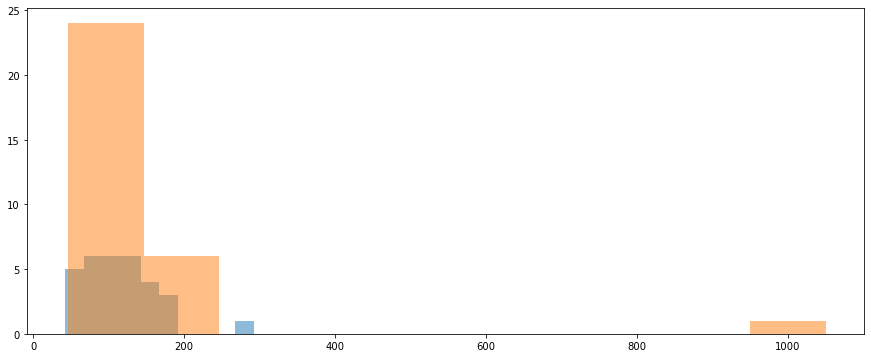

In [61]:
plt.hist(orders_A_daily['average_check'], alpha=0.5, label='Group A');
plt.hist(orders_B_daily['average_check'], alpha=0.5, label='Group B');

In [62]:
print('Mean group A:', orders_A_daily['average_check'].mean())
print('Mean group B:', orders_B_daily['average_check'].mean())
print('Median group A:', orders_A_daily['average_check'].median())
print('Median group B:', orders_B_daily['average_check'].median())

Mean group A: 115.51247176082741
Mean group B: 138.37116968351648
Median group A: 102.275
Median group B: 105.15882352941176


Now we can formulate hypotheses for testing:

- H0 (Null): There is no statistical significance between average order size of Group A and Group B.
- H1 (Alternative): Average order size of Group B is higher than average order size of Group A.

Since we are comparing the means of population we will either ttest or Mann-Whitney test for testing our hypotheses.
To define the exact test, we need to check whether our population have normal distiribution with the help of Shapiro test. 
If both of the samples have normal distribution we will use ttest, otherwise we will use test Mann_Whitney.

In [63]:
alpha = .05 # significance level

results1 = st.shapiro(orders_A_daily['average_check'])
p_value1 = results1[1] 

results2 = st.shapiro(orders_B_daily['average_check'])
p_value2 = results2[1]

if (p_value1 > alpha) and (p_value2 > alpha):
    print('Both samples seem to have normal distribution, ttest can be used')
else: 
    print('One of the samples has not normal distribution, test Mann_whitney should be used')

One of the samples has not normal distribution, test Mann_whitney should be used


In [64]:
alpha = .05 #significance level

results = st.mannwhitneyu(orders_A_daily['average_check'], orders_B_daily['average_check'])

print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
    print("Null hypothesis rejected: the difference is statistically significant")
else:
    print("Failed to reject the null hypothesis: we can't make conclusions about the difference")

p-value:  0.9550914317372012
Failed to reject the null hypothesis: we can't make conclusions about the difference


We can't conclude that there is a statistical significance of the difference in average order size between the groups

## Find the statistical significance of the difference in conversion between the groups using the filtered data

In [69]:
# Now we will create a dataframe and calculate conversion rate for group A: 
conversion_A_new = visits_A.merge(orders_A_daily_new[['date', 'orders']], how='left', on='date')
conversion_A_new['conversion'] = conversion_A_new['orders']/conversion_A_new['visits']

# And for group B:
conversion_B_new = visits_B.merge(orders_B_daily_new[['date', 'orders']], how='left', on='date')
conversion_B_new['conversion'] = conversion_B_new['orders']/conversion_B_new['visits']

### Total conversion check. Filtered data

In [67]:
A_trials = conversion_A_new['visits'].sum()
print("Trials:", A_trials)
A_successes = conversion_A_new['orders'].sum()
print("Successes:", A_successes)
print('Conversion Group A: {0:0.1%}'.format(A_successes/A_trials))

Trials: 18736
Successes: 446
Conversion Group A: 2.4%


In [70]:
B_trials = conversion_B_new['visits'].sum()
print("Trials:", A_trials)
B_successes = conversion_B_new['orders'].sum()
print("Successes:", A_successes)
print('Conversion Group A: {0:0.1%}'.format(B_successes/B_trials))

Trials: 18736
Successes: 446
Conversion Group A: 2.8%


Now we can formulate hypotheses for testing: 
    
- H0 (Null): There is no statistical significance between conversion of Group A and Group B. 
- H1 (Alternative): Conversion of Group B is higher than conversion of Group A. 
    
Since we are comparing proportion of two population we will use z-test for testing our hypotheses.  

In [71]:
alpha = .05 # significance level

successes = np.array([A_successes, B_successes])
trials = np.array([A_trials, B_trials])

# success proportion in the first group:
p1 = successes[0]/trials[0]

# success proportion in the second group:
p2 = successes[1]/trials[1]

# success proportion in the combined dataset:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# the difference between the datasets' proportions
difference = p1 - p2 

# calculating the statistic in standard deviations of the standard normal distribution
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# setting up the standard normal distribution (mean 0, standard deviation 1)
distr = st.norm(0, 1)  

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-value: ', p_value)

if (p_value < alpha):
    print("Rejecting the null hypothesis: there is a significant difference between the proportions")
else:
    print("Failed to reject the null hypothesis: there is no reason to consider the proportions different")

p-value:  0.005283098862493896
Rejecting the null hypothesis: there is a significant difference between the proportions


Since p value is less then 0.05 we can say that there is a statistically significant difference between the proportions. And since conversion rate of group B is more than group A (2.8% vs. 2.4%) we can conclude that conversion rate of group B is higher than the one of group A.  

### Average daily conversion. Filtered data

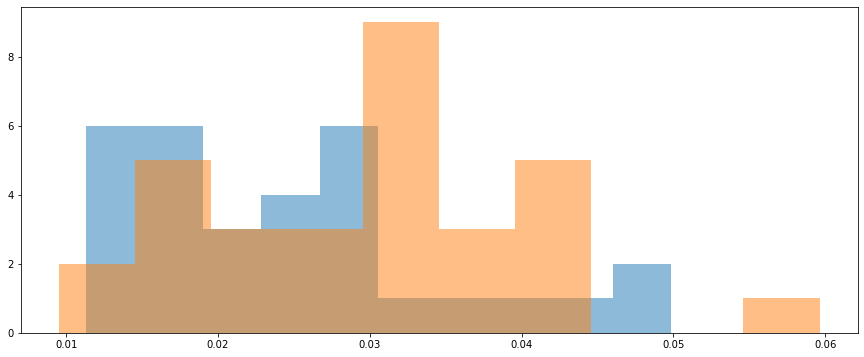

In [73]:
plt.hist(conversion_A_new['conversion'], alpha=0.5, label='Group A');
plt.hist(conversion_B_new['conversion'], alpha=0.5, label='Group B');

In [74]:
print('Mean group A:', conversion_A_new['conversion'].mean())
print('Mean group B:', conversion_B_new['conversion'].mean())
print('Median group A:', conversion_A_new['conversion'].median())
print('Median group B:', conversion_B_new['conversion'].median())

Mean group A: 0.024743232781016127
Mean group B: 0.02978812251589284
Median group A: 0.02312925170068027
Median group B: 0.030878859857482184


Now we can formulate hypotheses for testing:

- H0 (Null): There is no statistical significance between conversion of Group A and Group B.
- H1 (Alternative): Conversion of Group B is higher than conversion of Group A.

Since we are comparing the means of population we will either ttest or Mann-Whitney test for testing our hypotheses.
To define the exact test, we need to check whether our population have normal distiribution with the help of Shapiro test. 
If both of the samples have normal distribution we will use ttest, otherwise we will use tesst Mann_Whitney.

In [75]:
alpha = .05 # significance level

results1 = st.shapiro(conversion_A_new['conversion'])
p_value1 = results1[1] 

results2 = st.shapiro(conversion_B_new['conversion'])
p_value2 = results2[1]

if (p_value1 > alpha) and (p_value2 > alpha):
    print('Both samples seem to have normal distribution, ttest can be used')
else: 
    print('One of the samples has not normal distribution, test Mann Whitney should be used')

One of the samples has not normal distribution, test Mann Whitney should be used


In [76]:
alpha = .05 #significance level

results = st.mannwhitneyu(conversion_A_new['conversion'], conversion_B_new['conversion'])

print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
    print("Null hypothesis rejected: the difference is statistically significant")
else:
    print("Failed to reject the null hypothesis: we can't make conclusions about the difference")

p-value:  0.03123846586609714
Null hypothesis rejected: the difference is statistically significant


We can conclude that conversion rate of group B is higher that the conversion rate of group A (3% vs. 2.5%) since there is a statistically significant difference between conversion rate of two groups.

## Find the statistical significance of the difference in average order size between the groups using the filtered data.

In [77]:
orders_A_daily_new['average_check'] = orders_A_daily_new['revenue']/orders_A_daily_new['orders']
orders_B_daily_new['average_check'] = orders_B_daily_new['revenue']/orders_B_daily_new['orders']
orders_A_daily_new.head(3)
orders_B_daily_new.head(3)

,date,revenue,orders,cum_revenue,cum_orders,avg_order,cum_avg_order,average_check
0,2019-08-01,1779.3,18,1779.3,18,98.850000,98.850000,98.850000
1,2019-08-02,1438.3,18,3217.6,36,79.905556,89.377778,79.905556
2,2019-08-03,1815.2,24,5032.8,60,75.633333,83.880000,75.633333


,date,revenue,orders,cum_revenue,cum_orders,avg_order,cum_avg_order,average_check
0,2019-08-01,967.2,17,967.2,17,56.894118,56.894118,56.894118
1,2019-08-02,2568.1,23,3535.3,40,111.656522,88.382500,111.656522
2,2019-08-03,1071.6,14,4606.9,54,76.542857,85.312963,76.542857


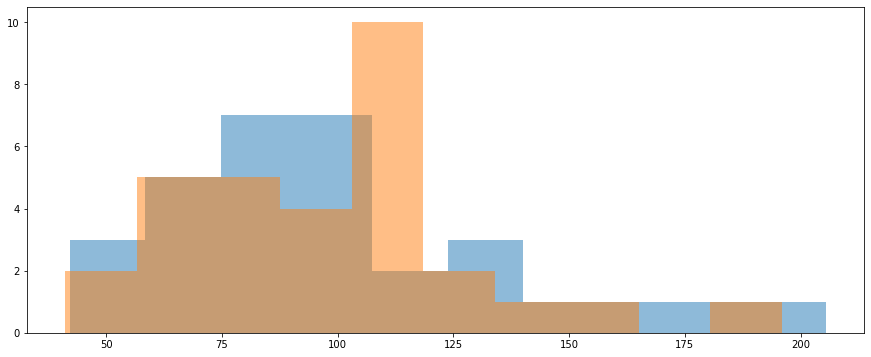

In [78]:
plt.hist(orders_A_daily_new['average_check'], alpha=0.5, label='Group A');
plt.hist(orders_B_daily_new['average_check'], alpha=0.5, label='Group B');

In [79]:
print('Mean group A:', orders_A_daily_new['average_check'].mean())
print('Mean group B:', orders_B_daily_new['average_check'].mean())
print('Median group A:', orders_A_daily_new['average_check'].median())
print('Median group B:', orders_B_daily_new['average_check'].median())

Mean group A: 98.95370075437548
Mean group B: 98.42674207036477
Median group A: 91.41666666666667
Median group B: 98.15384615384616


This time we have controvercial results, mean of group A is higher than B, when median is lower. In this case it seems that using median is more correct, since mean of both group is pretty close one to another (only 0.5% difference). So our hypotheses for testing are: 

- H0 (Null): There is no statistical significance between conversion of Group A and Group B.
- H1 (Alternative): Conversion of Group B is higher than conversion of Group A.

Since we are comparing the means of population we will either ttest or Mann-Whitney test for testing our hypotheses.
To define the exact test, we need to check whether our population have normal distiribution with the help of Shapiro test. 
If both of the samples have normal distribution we will use ttest, otherwise we will use tesst Mann_Whitney.

In [80]:
alpha = .05 # significance level

results1 = st.shapiro(orders_A_daily_new['average_check'])
p_value1 = results1[1] 

results2 = st.shapiro(orders_B_daily_new['average_check'])
p_value2 = results2[1]

if (p_value1 > alpha) and (p_value2 > alpha):
    print('Both samples seem to have normal distribution, ttest can be used')
else: 
    print('One of the samples has not normal distribution, test Mann_whitney should be used')

One of the samples has not normal distribution, test Mann_whitney should be used


In [81]:
alpha = .05 #significance level

results = st.mannwhitneyu(orders_A_daily_new['average_check'], orders_B_daily_new['average_check'])

print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
    print("Null hypothesis rejected: the difference is statistically significant")
else:
    print("Failed to reject the null hypothesis: we can't make conclusions about the difference")

p-value:  0.7460840109196356
Failed to reject the null hypothesis: we can't make conclusions about the difference


We can't conclude that there is s statistically significant difference between average order size of two groups. 

## Make a decision based on the test results. 

After conducting statistical tests, we got the following results:
1. There is the statistical significance of the difference in conversion rate between groups both for the total conversion check and for average daily conversion filtered data. We can conclude that group B has higher conversion rate compared to group A.


2. Both the raw data and filtered data didn't show a statistically significant difference between the groups in terms of average purchase size.
The graph of the difference in conversion between the groups shows none of the groups' results are significantly better than of the another.

Based on the results we have gotten, I would recommend to finish the test since we have founded that in one metric group B have better results and the difference was statistically significant, when in another metric we do not have a clear leader and there is no statistically significant difference between two groups. 